In [4]:
import mujoco
import numpy as np
from sim.integrators import LGVI
from sim.env_mj import MujocoEnv

In [5]:
model = "../models/resizable_box.xml"
mode = 'custom'
dt = 0.002
integ = LGVI(m=1.0, J=np.diag([0.01, 0.01, 0.01])) if mode == "custom" else None
env = MujocoEnv(model_path=model, dt=dt, integrator=integ,mode=mode, base_body_name="box")

DN: {'mode': 'twisting', 'alpha': 1.3507294784411092, 'm': 0.26371394697190575, 'p': 0.4, 'T': 8.466280595936151, 'E': 0.12500000000000008, 'm_consistency_check': -0.4791666666666663}
  numerics Δφ≈ 1.2000000000000002 Δψ≈ 0.8000000000000003


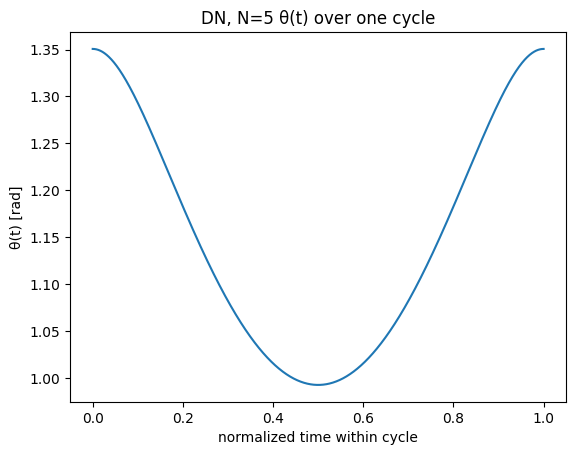

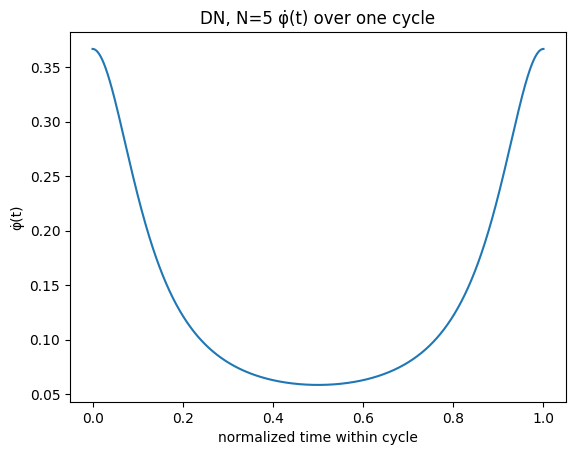

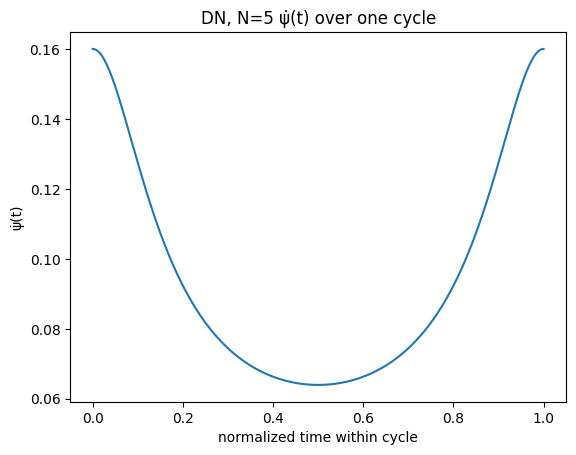

CN: {'mode': 'wobbling', 'alpha': 1.3538547854315064, 'm': -11.115572043182144, 'q': 0.3066856501907525, 'T': 10.0, 'E': 0.32283173590122627, 'm_consistency_check': 1.2882214407231714}
  numerics Δφ≈ 1.1999999999999997 Δψ≈ 0.8000000000000003


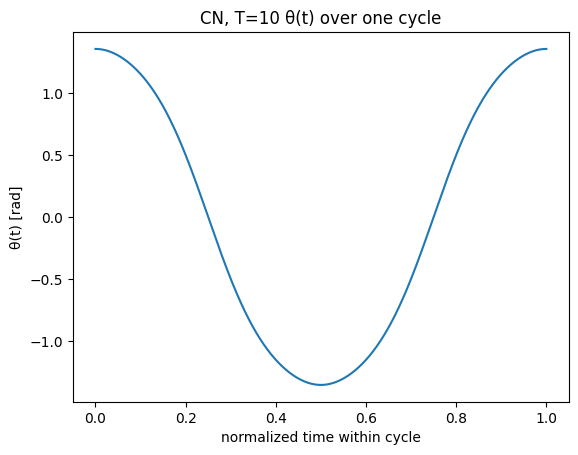

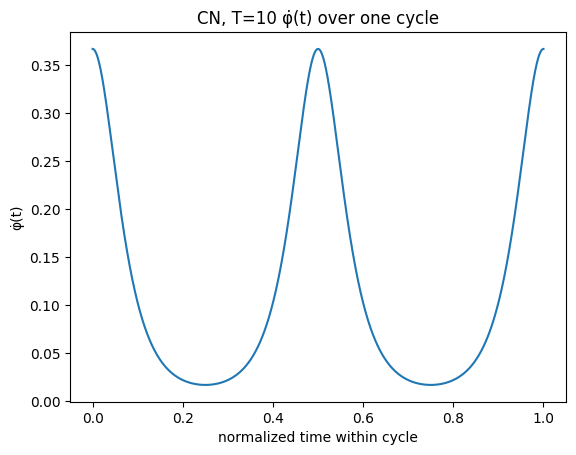

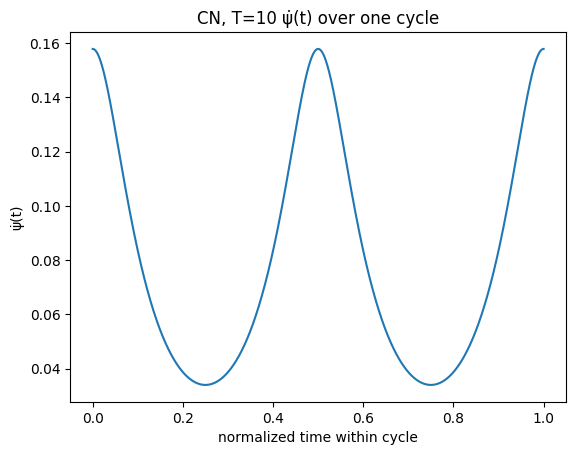

In [6]:
# Re-run the code (state was reset)
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

mp.mp.dps = 80

RF  = mp.elliprf
PiC = mp.ellippi
K   = mp.ellipk

def equations_dn(alpha, m, A, C, M, Delta_phi, Delta_psi, period_spec):
    A = mp.mpf(A); C = mp.mpf(C); M = mp.mpf(M)
    Delta_phi = mp.mpf(Delta_phi); Delta_psi = mp.mpf(Delta_psi)
    D = 1/C - 1/A

    t = mp.tan(alpha)
    n = - m * t*t

    if period_spec["type"] == "N":
        N = mp.mpf(period_spec["N"])
        rhs_phi = (Delta_phi * A) / (M * N)
        rhs_psi = (Delta_psi) / (M * N * D)
        r1 = PiC(n, m) - rhs_phi
        r2 = mp.cos(alpha) * RF(0, 1 + m*(t*t), 1 - m) - rhs_psi
        return r1, r2
    else:
        T = mp.mpf(period_spec["T"])
        Km = K(m)
        rhs_phi = (Delta_phi * A * Km) / (M * T)
        rhs_psi = (Delta_psi * Km) / (M * T * D)
        r1 = PiC(n, m) - rhs_phi
        r2 = mp.cos(alpha) * RF(0, 1 + m*(t*t), 1 - m) - rhs_psi
        return r1, r2

def equations_cn(alpha, m, A, C, M, Delta_phi, Delta_psi, period_spec):
    A = mp.mpf(A); C = mp.mpf(C); M = mp.mpf(M)
    Delta_phi = mp.mpf(Delta_phi); Delta_psi = mp.mpf(Delta_psi)
    D = 1/C - 1/A

    s  = mp.sin(alpha)
    c2 = mp.cos(alpha)**2
    n = - (s*s) / (1 - s*s)

    if period_spec["type"] == "N":
        N = mp.mpf(period_spec["N"])
        rhs_phi = (Delta_phi * A) / (M * N)
        rhs_psi = (Delta_psi) / (M * N * D)
        r1 = PiC(n, m) - rhs_phi
        r2 = mp.cos(alpha) * RF(0, 1/c2, 1 - m) - rhs_psi
        return r1, r2
    else:
        T = mp.mpf(period_spec["T"])
        Km = K(m)
        rhs_phi = (Delta_phi * A * Km) / (M * T)
        rhs_psi = (Delta_psi * Km) / (M * T * D)
        r1 = PiC(n, m) - rhs_phi
        r2 = mp.cos(alpha) * RF(0, 1/c2, 1 - m) - rhs_psi
        return r1, r2

def solve_motion(A, B, C, M, Delta_phi, Delta_psi, mode, period_spec,
                 alpha_guess=0.9, m_guess=0.5):
    if mode not in ("twisting", "wobbling"):
        raise ValueError("mode must be 'twisting' (dn) or 'wobbling' (cn)")
    if period_spec["type"] not in ("N","T"):
        raise ValueError("period_spec['type'] must be 'N' or 'T'")
    A = float(A); B = float(B); C = float(C); M = float(M)

    if mode == "twisting":
        eqfun = lambda a, m: equations_dn(a, m, A, C, M, Delta_phi, Delta_psi, period_spec)
    else:
        eqfun = lambda a, m: equations_cn(a, m, A, C, M, Delta_phi, Delta_psi, period_spec)

    alpha, m = mp.findroot(lambda a, mm: eqfun(a, mm), (alpha_guess, m_guess))
    Km = K(m)

    if mode == "twisting":
        if period_spec["type"] == "N":
            N = mp.mpf(period_spec["N"]); p = mp.mpf(2)/N; T = N*Km
        else:
            T = mp.mpf(period_spec["T"]); p = (2*Km)/T
        E = (M**2 - (p**2 * A * B * C)/(A - B)) / (2*C)
        m_check = ((B - C)*(2*E*A - M**2))/((A - B)*(M**2 - 2*E*C))
        return {"mode":"twisting","alpha":float(alpha),"m":float(m),"p":float(p),
                "T":float(T),"E":float(E),"m_consistency_check":float(m_check)}
    else:
        if period_spec["type"] == "N":
            N = mp.mpf(period_spec["N"]); q = mp.mpf(4)/N; T = N*Km
        else:
            T = mp.mpf(period_spec["T"]); q = (4*Km)/T
        E = (M**2 - (q**2 * A * B * C)/(A - B)) / (2*C)
        m_check = ((B - C)*(2*E*A - M**2))/((A - B)*(M**2 - 2*E*C))
        return {"mode":"wobbling","alpha":float(alpha),"m":float(m),"q":float(q),
                "T":float(T),"E":float(E),"m_consistency_check":float(m_check)}

def _jacobi_dn(u, m):
    z = mp.ellipfun('dn', u, m)
    return float(mp.re(z))

def _jacobi_cn(u, m):
    z = mp.ellipfun('cn', u, m)
    return float(mp.re(z))

def simulate_one_cycle(mode, alpha, m, A, B, C, M, p_or_q, num_points=2000):
    A = float(A); B = float(B); C = float(C); M = float(M)
    D = 1.0/C - 1.0/A
    Km = float(K(m))
    if mode == "twisting":
        p = float(p_or_q)
        T = 2*Km/p
        f = lambda u: _jacobi_dn(u, m)
    elif mode == "wobbling":
        q = float(p_or_q)
        T = 4*Km/q
        f = lambda u: _jacobi_cn(u, m)
    else:
        raise ValueError("mode must be 'twisting' or 'wobbling'")

    t = np.linspace(0.0, T, num_points)
    s = float(mp.sin(alpha))
    c2 = float(mp.cos(alpha)**2)

    theta  = np.empty_like(t)
    phidot = np.empty_like(t)
    psidot = np.empty_like(t)

    for i, tt in enumerate(t):
        u = (p_or_q) * tt
        base = f(u)
        x = s*base
        if x > 1.0:  x = 1.0
        if x < -1.0: x = -1.0
        theta[i] = np.arcsin(x)
        denom = 1.0 - (s*s)*(base*base)
        phidot[i] = (M/A) * c2 / denom
        psidot[i] = (M*D) * c2 / np.sqrt(denom)

    return t, theta, phidot, psidot

def plot_one_cycle(t, theta, phidot, psidot, title_prefix=""):
    plt.figure()
    plt.plot(t/t[-1], theta)
    plt.xlabel("normalized time within cycle")
    plt.ylabel("θ(t) [rad]")
    plt.title((title_prefix + " θ(t) over one cycle").strip())
    plt.show()

    plt.figure()
    plt.plot(t/t[-1], phidot)
    plt.xlabel("normalized time within cycle")
    plt.ylabel("φ̇(t)")
    plt.title((title_prefix + " φ̇(t) over one cycle").strip())
    plt.show()

    plt.figure()
    plt.plot(t/t[-1], psidot)
    plt.xlabel("normalized time within cycle")
    plt.ylabel("ψ̇(t)")
    plt.title((title_prefix + " ψ̇(t) over one cycle").strip())
    plt.show()

# ----------------------------- DEMO ---------------------------------------------
if __name__ == "__main__":
    A, B, C = 3.0, 2.0, 1.0
    M = 1.1
    Delta_phi, Delta_psi = 1.20, 0.80

    # DN / twisting with integer N
    out_dn = solve_motion(A,B,C,M,Delta_phi,Delta_psi,
                          mode="twisting", period_spec={"type":"N","N":5},
                          alpha_guess=0.9, m_guess=0.6)
    print("DN:", out_dn)
    t, th, ph, ps = simulate_one_cycle("twisting", out_dn["alpha"], out_dn["m"],
                                       A,B,C,M, out_dn["p"])
    dphi_num = np.trapezoid(ph, t); dpsi_num = np.trapezoid(ps, t)
    print("  numerics Δφ≈", float(dphi_num), "Δψ≈", float(dpsi_num))
    plot_one_cycle(t, th, ph, ps, title_prefix="DN, N=5")

    # CN / wobbling with numeric T
    out_cn = solve_motion(A,B,C,M,Delta_phi,Delta_psi,
                          mode="wobbling", period_spec={"type":"T","T":10.0},
                          alpha_guess=0.9, m_guess=0.6)
    print("CN:", out_cn)
    t2, th2, ph2, ps2 = simulate_one_cycle("wobbling", out_cn["alpha"], out_cn["m"],
                                           A,B,C,M, out_cn["q"])
    dphi_num2 = np.trapezoid(ph2, t2); dpsi_num2 = np.trapezoid(ps2, t2)
    print("  numerics Δφ≈", float(dphi_num2), "Δψ≈", float(dpsi_num2))
    plot_one_cycle(t2, th2, ph2, ps2, title_prefix="CN, T=10")
